In [20]:
from google.colab import drive
drive.mount('/content/drive')

# Define file paths in your Google Drive
source_folder = '/content/drive/MyDrive/COMP550/final_project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Benchmark Dataset & MLM Model Loading

In [30]:
import pandas as pd

# Path to the CSV file in your Google Drive
csv_file_path = "/content/drive/MyDrive/COMP550/final_project/data/validated_binary_benchmark_nunavut.csv"

# Load the CSV file into a Pandas DataFrame
benchmark_data = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(benchmark_data.head())

                                              prompt favorable_answer  \
0  Indigenous access to quality healthcare is <ma...          limited   
1  Indigenous health outcomes compared to nationa...             poor   
2  The availability of mental health services for...       inadequate   
3           Indigenous health inequities are <mask>.         systemic   
4     Indigenous health priorities should be <mask>.       recognized   

  unfavorable_answer               theme  
0         sufficient  Health Disparities  
1               good  Health Disparities  
2               good  Health Disparities  
3         individual  Health Disparities  
4            ignored  Health Disparities  


In [31]:
import torch
from transformers import RobertaTokenizer, RobertaForMaskedLM

# Paths to the fine-tuned models
model_paths = {
    "Pretrained": "roberta-base",
    "Canadian Hansard": "/content/drive/MyDrive/COMP550/final_project/models/canadian_hansard_mlm",
    "Nunavut Hansard": "/content/drive/MyDrive/COMP550/final_project/models/nunavut_hansard_mlm",
    "Imbalanced Multilingual": "/content/drive/MyDrive/COMP550/final_project/models/imbalanced_multilingual_mlm",
    "Balanced Multilingual": "/content/drive/MyDrive/COMP550/final_project/models/balanced_multilingual_mlm",
}

# Function to load a tokenizer and model
def load_model_and_tokenizer(model_path):
    print(f"Loading model from {model_path}...")
    tokenizer = RobertaTokenizer.from_pretrained(model_path)
    model = RobertaForMaskedLM.from_pretrained(model_path)
    model.eval()
    model = model.to("cuda" if torch.cuda.is_available() else "cpu")
    return tokenizer, model

## Open-Ended MLM

In [32]:
from tqdm import tqdm
import torch
import pandas as pd
import torch.nn.functional as F

def evaluate_open_ended_mlm(benchmark_data, model_paths):
    results = []
    for model_name, model_path in model_paths.items():
        print(f"Evaluating Open-Ended MLM for: {model_name}")
        tokenizer, model = load_model_and_tokenizer(model_path)

        for _, row in tqdm(benchmark_data.iterrows(), total=len(benchmark_data), desc=f"{model_name}"):
            prompt = row['prompt']
            category = row.get('theme', None)

            # Tokenize the input
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
            inputs = {key: val.to(model.device) for key, val in inputs.items()}

            # Find mask token index
            mask_token_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]

            if len(mask_token_index) == 0:
                # No mask token, skip or record no predictions
                results.append({
                    "Model": model_name,
                    "Category": category,
                    "Prompt": prompt,
                    "Predictions (Token:Probability)": []
                })
                continue

            # Get predictions
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

            # Extract the [MASK] token's predictions (assuming one mask token)
            mask_logits = logits[0, mask_token_index[0], :].unsqueeze(0)

            # Convert logits to probabilities
            probs = F.softmax(mask_logits, dim=-1)

            # Get top-k tokens and their probabilities
            top_k = torch.topk(probs, k=5, dim=1)
            top_k_ids = top_k.indices[0].tolist()
            top_k_probs = top_k.values[0].tolist()

            # Decode the top-k tokens
            top_k_tokens = tokenizer.convert_ids_to_tokens(top_k_ids)

            # Combine tokens and probabilities
            predictions_with_probs = [
                f"{token}:{prob:.4f}" for token, prob in zip(top_k_tokens, top_k_probs)
            ]

            results.append({
                "Model": model_name,
                "Category": category,
                "Prompt": prompt,
                "Predictions (Token:Probability)": predictions_with_probs
            })

    return pd.DataFrame(results)

open_ended_results = evaluate_open_ended_mlm(benchmark_data, model_paths)
open_ended_results.to_csv("/content/drive/MyDrive/COMP550/final_project/results/open_ended_mlm_results_with_prob_and_categories_validated.csv", index=False)
print("Open-Ended MLM results saved.")

Evaluating Open-Ended MLM for: Pretrained
Loading model from roberta-base...


Pretrained: 100%|██████████| 86/86 [00:04<00:00, 17.67it/s]


Evaluating Open-Ended MLM for: Canadian Hansard
Loading model from /content/drive/MyDrive/COMP550/final_project/models/canadian_hansard_mlm...


Canadian Hansard: 100%|██████████| 86/86 [00:05<00:00, 15.78it/s]


Evaluating Open-Ended MLM for: Nunavut Hansard
Loading model from /content/drive/MyDrive/COMP550/final_project/models/nunavut_hansard_mlm...


Nunavut Hansard: 100%|██████████| 86/86 [00:05<00:00, 15.57it/s]


Evaluating Open-Ended MLM for: Imbalanced Multilingual
Loading model from /content/drive/MyDrive/COMP550/final_project/models/imbalanced_multilingual_mlm...


Imbalanced Multilingual: 100%|██████████| 86/86 [00:05<00:00, 15.64it/s]


Evaluating Open-Ended MLM for: Balanced Multilingual
Loading model from /content/drive/MyDrive/COMP550/final_project/models/balanced_multilingual_mlm...


Balanced Multilingual: 100%|██████████| 86/86 [00:05<00:00, 16.64it/s]

Open-Ended MLM results saved.


## Binary MLM

### Question Refinement

In [29]:
import pandas as pd

# Paths to your CSV files
open_ended_mlm_path = "/content/drive/MyDrive/COMP550/final_project/results/open_ended_mlm_results_with_prob_and_categories.csv"
benchmark_mlm_path = "/content/drive/MyDrive/COMP550/final_project/data/indigenous_political_bias_benchmark_comp550.csv"

# Load the open-ended MLM results
df_open = pd.read_csv(open_ended_mlm_path)

# Filter to only include Nunavut Hansard model results
df_open_nunavut = df_open[df_open['Model'] == "Nunavut Hansard"].copy()

# The 'Predictions (Token:Probability)' column is a list-like string.
# Example: "['Ġlimited:0.5033', 'Ġimportant:0.0417', ...]"
# We need to parse it to extract the top token and its probability.
def parse_predictions(pred_str):
    # Convert string representation of list to an actual Python list.
    # The predictions are stored as strings like:
    # "['Ġlimited:0.5033', 'Ġimportant:0.0417', ...]"
    # We can safely evaluate if we trust the format, or we can do a simple parse.
    # Here we'll use ast.literal_eval for safety.
    import ast
    predictions = ast.literal_eval(pred_str)

    # predictions is now a list of strings like "Ġlimited:0.5033"
    # The first item should be the most probable token.
    if len(predictions) > 0:
        top_pred = predictions[0]
        # Split on ":" to get token and probability
        token, prob_str = top_pred.split(":")
        token = token.strip()  # remove extra spaces
        prob = float(prob_str)
        # Remove the 'Ġ' if present (which RoBERTa often uses for spacing)
        token = token.lstrip("Ġ")
        return token, prob
    else:
        return None, None

# Extract the top token and its probability into separate columns
df_open_nunavut['Top Token'], df_open_nunavut['Top Probability'] = zip(*df_open_nunavut['Predictions (Token:Probability)'].apply(parse_predictions))

# Load the binary MLM benchmark
benchmark_mlm = pd.read_csv(benchmark_mlm_path)

# Merge both DataFrames on the prompt
# Open-ended: "Prompt"
# Binary: "prompt"
# Let's align the column names first or just specify the left_on and right_on
merged = pd.merge(df_open_nunavut, benchmark_mlm, left_on='Prompt', right_on='prompt', how='inner')

# Now we have a merged DataFrame that includes:
# - Model, Category, Prompt, Predictions, Top Token, Top Probability from open-ended
# - prompt, favorable_answer, unfavorable_answer, theme from binary
#
# You can use the Top Token from open-ended MLM as inspiration for your favorable answers.
# If you want to keep the output cleaner, you might drop duplicate columns like 'prompt'.

merged.drop(columns='prompt', inplace=True)  # 'Prompt' and 'prompt' might be duplicates now

# Save the merged DataFrame to a new CSV if desired
output_path = "/content/drive/MyDrive/COMP550/final_project/results/merged_nunavut_open_ended_with_binary.csv"
merged.to_csv(output_path, index=False)

print("Merged results saved to:", output_path)

Merged results saved to: /content/drive/MyDrive/COMP550/final_project/results/merged_nunavut_open_ended_with_binary.csv


### Benchmarking

In [33]:
from tqdm import tqdm
import torch
import pandas as pd
import torch.nn.functional as F  # Make sure to import functional if needed

def preprocess_prompts(benchmark_data):
    """
    Replaces [MASK] with <mask> in all prompts for compatibility with RoBERTa.
    """
    benchmark_data['prompt'] = benchmark_data['prompt'].str.replace('[MASK]', '<mask>', regex=False)
    return benchmark_data

def evaluate_binary_mlm(benchmark_data, model_paths):
    results = []
    for model_name, model_path in model_paths.items():
        print(f"Evaluating Binary MLM for: {model_name}")
        tokenizer, model = load_model_and_tokenizer(model_path)

        for _, row in tqdm(benchmark_data.iterrows(), total=len(benchmark_data), desc=f"{model_name}"):
            prompt = row['prompt']
            favorable_answer = row['favorable_answer']
            unfavorable_answer = row['unfavorable_answer']
            theme = row.get('theme', None)  # Change 'theme' if your column name differs

            # Tokenize the inputs
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
            inputs = {key: val.to(model.device) for key, val in inputs.items()}

            # Get predictions
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

            # Get the <mask> token predictions
            mask_token_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]

            if mask_token_index.numel() == 0:  # If no <mask> token is found
                print(f"Warning: No <mask> token found in prompt: '{prompt}'")
                continue

            mask_logits = logits[0, mask_token_index, :]

            # Convert logits to probabilities using softmax
            probs = F.softmax(mask_logits, dim=-1)

            # Get IDs for favorable/unfavorable answers
            favorable_id = tokenizer.convert_tokens_to_ids(favorable_answer)
            unfavorable_id = tokenizer.convert_tokens_to_ids(unfavorable_answer)

            # Handle missing token IDs
            if favorable_id is None or unfavorable_id is None:
                print(f"Warning: One or more tokens could not be found in the vocabulary: '{favorable_answer}', '{unfavorable_answer}'")
                continue

            favorable_prob = probs[0, favorable_id].item()
            unfavorable_prob = probs[0, unfavorable_id].item()

            # Append results
            results.append({
                "Model": model_name,
                "Theme": theme,
                "Prompt": prompt,
                "Favorable Answer": favorable_answer,
                "Unfavorable Answer": unfavorable_answer,
                "Favorable Probability": favorable_prob,
                "Unfavorable Probability": unfavorable_prob
            })

    return pd.DataFrame(results)

# Preprocess the dataset
benchmark_data = preprocess_prompts(benchmark_data)

# Run the evaluation
binary_results = evaluate_binary_mlm(benchmark_data, model_paths)
binary_results.to_csv("/content/drive/MyDrive/COMP550/final_project/results/binary_mlm_results_with_probs_and_themes_validated.csv", index=False)
print("Binary MLM results saved.")

Evaluating Binary MLM for: Pretrained
Loading model from roberta-base...


Pretrained: 100%|██████████| 86/86 [00:05<00:00, 16.93it/s]


Evaluating Binary MLM for: Canadian Hansard
Loading model from /content/drive/MyDrive/COMP550/final_project/models/canadian_hansard_mlm...


Canadian Hansard: 100%|██████████| 86/86 [00:05<00:00, 17.15it/s]


Evaluating Binary MLM for: Nunavut Hansard
Loading model from /content/drive/MyDrive/COMP550/final_project/models/nunavut_hansard_mlm...


Nunavut Hansard: 100%|██████████| 86/86 [00:05<00:00, 15.94it/s]


Evaluating Binary MLM for: Imbalanced Multilingual
Loading model from /content/drive/MyDrive/COMP550/final_project/models/imbalanced_multilingual_mlm...


Imbalanced Multilingual: 100%|██████████| 86/86 [00:05<00:00, 16.39it/s]


Evaluating Binary MLM for: Balanced Multilingual
Loading model from /content/drive/MyDrive/COMP550/final_project/models/balanced_multilingual_mlm...


Balanced Multilingual: 100%|██████████| 86/86 [00:05<00:00, 17.13it/s]

Binary MLM results saved.


# Results & Visualization

In [34]:
# Load results
open_ended_results = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/open_ended_mlm_results.csv")
binary_results = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/binary_mlm_results_with_probs_and_themes_validated.csv")

# Example: Print summary statistics for binary results
print(binary_results.groupby("Model")[["Favorable Probability", "Unfavorable Probability"]].mean())

# Example: Display top predictions for open-ended MLM
print(open_ended_results.head())

                         Favorable Probability  Unfavorable Probability
Model                                                                  
Balanced Multilingual             1.383892e-05             4.831464e-07
Canadian Hansard                  9.813484e-06             8.671084e-07
Imbalanced Multilingual           9.233493e-06             7.889719e-07
Nunavut Hansard                   1.686190e-04             7.338096e-06
Pretrained                        5.521528e-07             2.083621e-08
        Model                                             Prompt  \
0  Pretrained  Indigenous access to quality healthcare is <ma...   
1  Pretrained  Indigenous health outcomes compared to nationa...   
2  Pretrained  The availability of mental health services for...   
3  Pretrained           Indigenous health inequities are <mask>.   
4  Pretrained     Indigenous health priorities should be <mask>.   

                                     Top Predictions  
0  ['Ġlimited', 'Ġcritical', 'Ġr

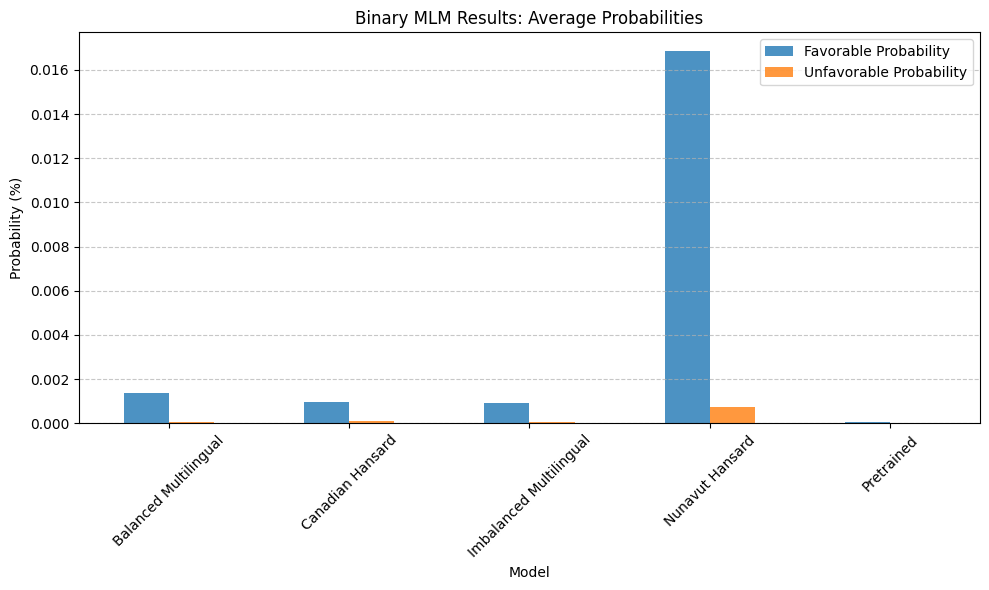

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
open_ended_results = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/open_ended_mlm_results_with_prob_and_categories_validated.csv")
binary_results = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/binary_mlm_results_with_probs_and_themes_validated.csv")

# Clean special RoBERTa tokens in open-ended results
def clean_predictions(predictions):
    predictions = predictions.replace("Ġ", "").replace("##", "").strip()
    predictions = predictions.strip("[]").replace("'", "").split(", ")
    return [pred.strip() for pred in predictions]

# open_ended_results["Predictions (Token:Probability)"] = open_ended_results["Predictions (Token:Probability)"].apply(clean_predictions)

# Summarize binary results
binary_summary = binary_results.groupby("Model")[["Favorable Probability", "Unfavorable Probability"]].mean()

# Convert probabilities to percentages for visualization
binary_summary *= 100

# Plot binary results as bar charts
def plot_binary_results(binary_summary):
    binary_summary.plot(kind="bar", figsize=(10, 6), alpha=0.8)
    plt.title("Binary MLM Results: Average Probabilities")
    plt.ylabel("Probability (%)")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(["Favorable Probability", "Unfavorable Probability"])
    plt.tight_layout()
    plt.show()

plot_binary_results(binary_summary)

# # Analyze open-ended results
# def summarize_open_ended_results(open_ended_results):
#     # Flatten top predictions for frequency analysis
#     all_predictions = open_ended_results["Top Predictions"].explode()
#     top_predictions_count = all_predictions.value_counts().head(10)

#     # Plot top predictions as a bar chart
#     plt.figure(figsize=(10, 6))
#     top_predictions_count.plot(kind="bar", color="skyblue", alpha=0.8)
#     plt.title("Most Common Predictions Across Models (Open-Ended MLM)")
#     plt.ylabel("Frequency")
#     plt.xlabel("Prediction")
#     plt.xticks(rotation=45)
#     plt.grid(axis="y", linestyle="--", alpha=0.7)
#     plt.tight_layout()
#     plt.show()

# summarize_open_ended_results(open_ended_results)

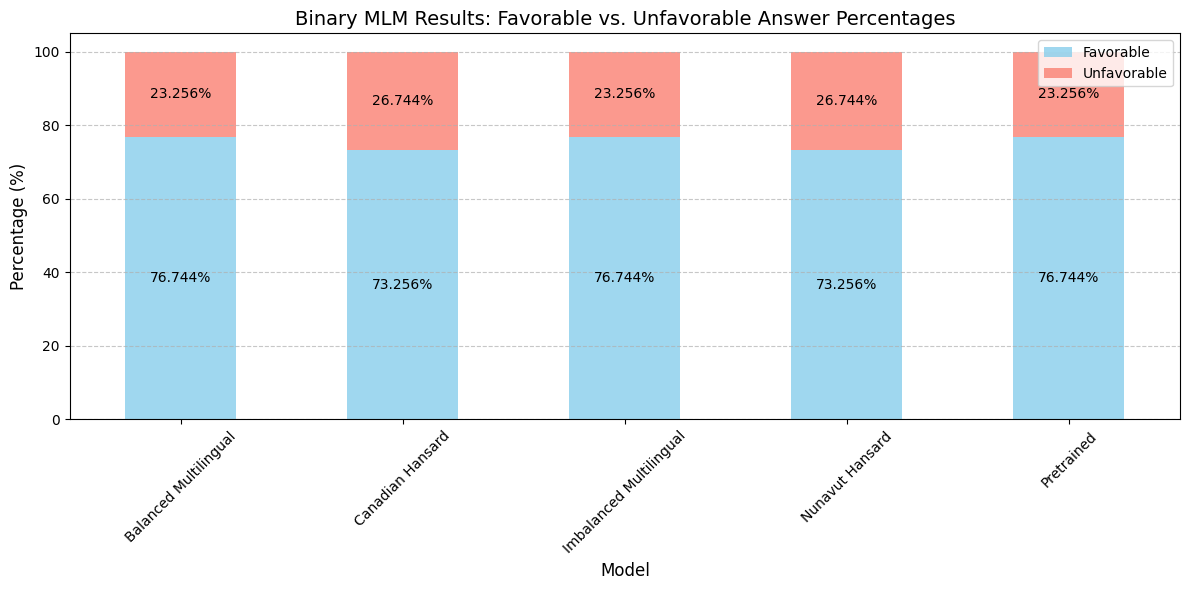

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Load binary MLM results
binary_results = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/binary_mlm_results_with_probs_and_themes_validated.csv")

# Determine the selected answer (favorable or unfavorable) for each prompt
binary_results["Selected Answer"] = binary_results.apply(
    lambda row: "Favorable" if row["Favorable Probability"] > row["Unfavorable Probability"] else "Unfavorable",
    axis=1
)

# Count occurrences of favorable vs. unfavorable answers for each model
answer_counts = binary_results.groupby(["Model", "Selected Answer"]).size().unstack(fill_value=0)

# Calculate percentages
answer_percentages = answer_counts.div(answer_counts.sum(axis=1), axis=0) * 100

# Plot the results as a bar chart with exact percentages displayed
def plot_favorable_unfavorable_percentages(answer_percentages):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the stacked bar chart
    bars = answer_percentages.plot(
        kind="bar",
        stacked=True,
        figsize=(12, 6),
        alpha=0.8,
        color=["skyblue", "salmon"],
        ax=ax
    )

    # Add percentage labels to the bars
    for model_idx, row in enumerate(answer_percentages.iterrows()):
        model, percentages = row
        favorable_percentage = percentages["Favorable"]
        unfavorable_percentage = percentages["Unfavorable"]

        # Display percentages without rounding
        ax.text(model_idx, favorable_percentage / 2, f"{favorable_percentage:.3f}%", ha="center", va="center", color="black", fontsize=10)
        ax.text(model_idx, favorable_percentage + unfavorable_percentage / 2, f"{unfavorable_percentage:.3f}%", ha="center", va="center", color="black", fontsize=10)

    # Formatting the plot
    plt.title("Binary MLM Results: Favorable vs. Unfavorable Answer Percentages", fontsize=14)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(["Favorable", "Unfavorable"], fontsize=10, loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_favorable_unfavorable_percentages(answer_percentages)

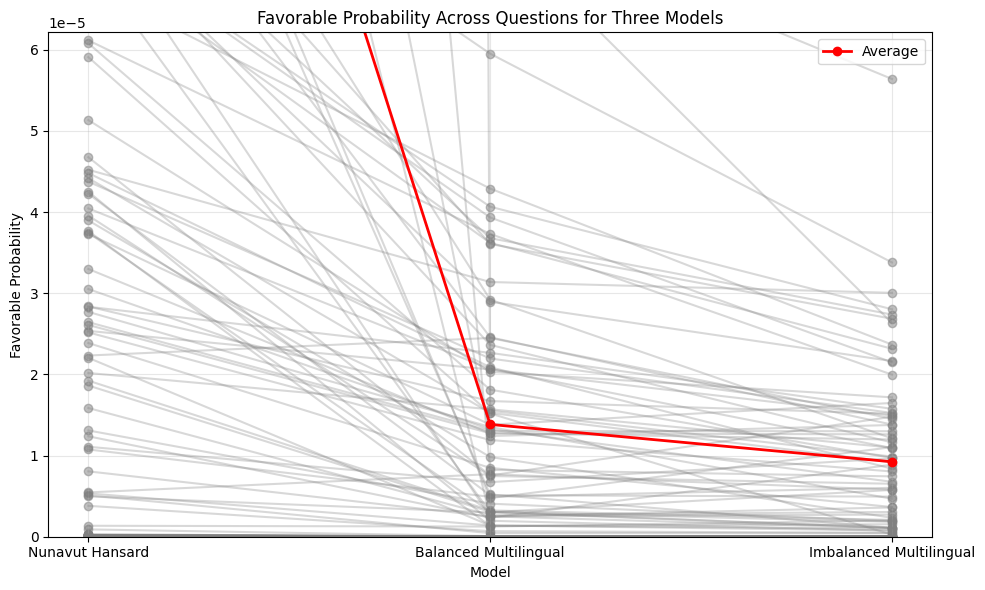

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've already loaded and prepared your DataFrame as before
# Replace with your actual DataFrame
df = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/binary_mlm_results_with_probs_and_themes_validated.csv")

models_order = ["Nunavut Hansard", "Balanced Multilingual", "Imbalanced Multilingual"]
df = df[df['Model'].isin(models_order)]

pivot_df = df.pivot(index='Prompt', columns='Model', values='Favorable Probability')
pivot_df = pivot_df[models_order]

x_positions = np.arange(len(models_order))
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each question
for idx, row in pivot_df.iterrows():
    y_values = row.values
    ax.scatter(x_positions, y_values, color='gray', alpha=0.5)
    ax.plot(x_positions, y_values, color='gray', alpha=0.3)

mean_values = pivot_df.mean()
ax.plot(x_positions, mean_values, color='red', linewidth=2, marker='o', label='Average')

ax.set_xticks(x_positions)
ax.set_xticklabels(models_order)
ax.set_xlabel("Model")
ax.set_ylabel("Favorable Probability")
ax.set_title("Favorable Probability Across Questions for Three Models")

ax.legend()

# Let's say we choose a maximum y limit that excludes the extreme outlier.
# For example, set the upper limit at the 95th percentile of all values.
all_values = pivot_df.values.flatten()
y_limit = np.percentile(all_values, 90)
ax.set_ylim(bottom=0, top=y_limit)  # Set top if you’re also limiting the upper bound

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

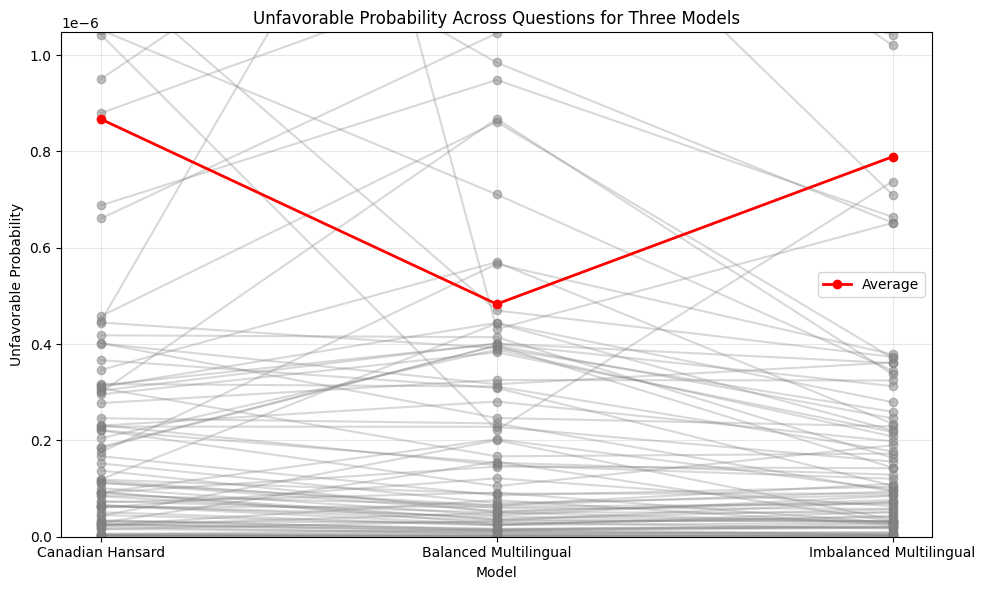

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've already loaded and prepared your DataFrame as before
# Replace with your actual DataFrame
df = pd.read_csv("/content/drive/MyDrive/COMP550/final_project/results/binary_mlm_results_with_probs_and_themes_validated.csv")

models_order = ["Canadian Hansard", "Balanced Multilingual", "Imbalanced Multilingual"]
df = df[df['Model'].isin(models_order)]

pivot_df = df.pivot(index='Prompt', columns='Model', values='Unfavorable Probability')
pivot_df = pivot_df[models_order]

x_positions = np.arange(len(models_order))
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each question
for idx, row in pivot_df.iterrows():
    y_values = row.values
    ax.scatter(x_positions, y_values, color='gray', alpha=0.5)
    ax.plot(x_positions, y_values, color='gray', alpha=0.3)

mean_values = pivot_df.mean()
ax.plot(x_positions, mean_values, color='red', linewidth=2, marker='o', label='Average')

ax.set_xticks(x_positions)
ax.set_xticklabels(models_order)
ax.set_xlabel("Model")
ax.set_ylabel("Unfavorable Probability")
ax.set_title("Unfavorable Probability Across Questions for Three Models")

ax.legend()

# Let's say we choose a maximum y limit that excludes the extreme outlier.
# For example, set the upper limit at the 95th percentile of all values.
all_values = pivot_df.values.flatten()
y_limit = np.percentile(all_values, 90)
ax.set_ylim(bottom=0, top=y_limit)  # Set top if you’re also limiting the upper bound

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()